<a href="https://colab.research.google.com/github/DKH707/B-ODE-DM/blob/kyle-dev/covid19_Cook_Earp_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009472
- https://arxiv.org/abs/2302.09125
- https://github.com/stefanradev93/BayesFlow
- https://github.com/bayesflow-org/JANA-Paper
- https://github.com/stefanradev93/AIAgainstCorona/tree/main
- https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

#Install Packages

In [1]:
! pip install git+https://github.com/stefanradev93/BayesFlow
! pip install -U ipython-autotime wbgapi #numpy pandas tensorflow
! pip install properscoring
get_ipython().kernel.do_shutdown(True)

  Cloning https://github.com/stefanradev93/BayesFlow to /tmp/pip-req-build-2y1n5fga
  Running command git clone --filter=blob:none --quiet https://github.com/stefanradev93/BayesFlow /tmp/pip-req-build-2y1n5fga
  Resolved https://github.com/stefanradev93/BayesFlow to commit ee97f356728cf562eb30387156babc16dcf664d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 17.8 MB/s eta 0:00:00
  Created wheel for bayesflow: filename=bayesflow-1.1.3.dev8+gee97f35-py3-none-any.whl size=178048 sha256=e14d359ea0cadd8497849d30c37f5814425792a51a8dcf938d8b202af0d5f497
  Stored in directory: /tmp/pip-ephem-wheel-cache-n3c_g78e/wheels/83/d6/3b/ede477857e8142fd0dfcec6625786f484543ef8dcbb17f4266
Successfully

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00


{'status': 'ok', 'restart': True}

#Setup

##Imports & Globals

In [1]:
%reload_ext autotime
import os, warnings, datetime, pathlib, shutil, google.colab, dataclasses, pickle, wbgapi
import numpy as np, pandas as pd, tensorflow as tf
import properscoring as ps
import matplotlib.pyplot as plt, seaborn as sns
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM
from bayesflow.networks import InvertibleNetwork, SequentialNetwork
from bayesflow.coupling_networks import CouplingLayer
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.amortizers import AmortizedLikelihood, AmortizedPosterior, AmortizedPosteriorLikelihood
from bayesflow.trainers import Trainer
from bayesflow import default_settings
from bayesflow.helper_functions import build_meta_dict
import bayesflow.diagnostics as diag
from bayesflow.computational_utilities import maximum_mean_discrepancy
warnings.filterwarnings("ignore", message="Could not infer format, so each element will be parsed individually")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "text.latex.preamble": r"\usepackage{{amsmath}}"})
mnt = '/content/drive'
google.colab.drive.mount(mnt)
RNG = np.random.default_rng(42)
EPS = 1e-6

/usr/local/lib/python3.10/dist-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Mounted at /content/drive
time: 33.7 s (started: 2023-07-25 20:41:08 +00:00)


##Bespoke TensorFlow Code from JANA Repo that may not be necessary https://github.com/bayesflow-org/JANA-Paper/blob/main/experiments/epidemiology/covid19_joint_memory_MMD.ipynb

In [2]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""

    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()

        self.convs = [
            tf.keras.layers.Conv1D(
                n_filters // 2,
                kernel_size=f,
                strides=strides,
                padding="causal",
                activation="relu",
                kernel_initializer="glorot_uniform",
            )
            for f in range(2, 8)
        ]
        self.dim_red = tf.keras.layers.Conv1D(
            n_filters, 1, 1, activation="relu", kernel_initializer="glorot_uniform"
        )

    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""

        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out


class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""

    def __init__(self, n_layers=3, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()

        self.net = tf.keras.Sequential(
            [MultiConvLayer(n_filters, strides) for _ in range(n_layers)]
        )

        self.lstm = LSTM(n_filters)

    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""

        out = self.net(x)
        out = self.lstm(out)
        return out


class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary):
        super(SummaryNet, self).__init__()
        self.net_I = MultiConvNet(n_filters=n_summary // 3)
        self.net_R = MultiConvNet(n_filters=n_summary // 3)
        self.net_D = MultiConvNet(n_filters=n_summary // 3)

    @tf.function
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""

        x = tf.split(x, 3, axis=-1)
        x_i = self.net_I(x[0])
        x_r = self.net_R(x[1])
        x_d = self.net_D(x[2])
        return tf.concat([x_i, x_r, x_d], axis=-1)

class MemoryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(MemoryNetwork, self).__init__()

        self.gru = GRU(meta["n_hidden"], return_sequences=True, return_state=True)
        self.h = meta["n_hidden"]
        self.n_params = meta["n_params"]

    @tf.function
    def call(self, target, condition):
        """Performs a forward pass through the network.

        Params:
        -------
        target    : tf.Tesnor of shape (batch_size, time_stes, dim)
            The time-dependent signal to process.
        condition : tf.Tensor of shape (batch_size, cond_dim)
            The conditional (static) variables, e.g., parameters.
        """
        shift_target = target[:, :-1, :]
        init = tf.zeros((target.shape[0], 1, target.shape[2]))
        inp_teacher = tf.concat([init, shift_target], axis=1)
        inp_teacher_c = tf.concat([inp_teacher, condition], axis=-1)
        out, _ = self.gru(inp_teacher_c)
        return out

    def step_loop(self, target, condition, state):
        out, new_state = self.gru(
            tf.concat([target, condition], axis=-1), initial_state=state
        )
        return out, new_state

class InvertibleNetworkWithMemory(tf.keras.Model):
    """Implements a chain of conditional invertible blocks for Bayesian parameter inference."""

    def __init__(
        self,
        num_params,
        num_coupling_layers=4,
        coupling_settings=None,
        coupling_design="affine",
        permutation="fixed",
        use_act_norm=True,
        act_norm_init=None,
        use_soft_flow=False,
        soft_flow_bounds=(1e-3, 5e-2),
    ):
        """Initializes a custom invertible network with recurrent memory."""

        super().__init__()

        # Create settings dict for coupling layer
        settings = dict(
            latent_dim=num_params,
            coupling_settings=coupling_settings,
            coupling_design=coupling_design,
            permutation=permutation,
            use_act_norm=use_act_norm,
            act_norm_init=act_norm_init,
        )

        # Create sequence of coupling layers and store reference to dimensionality
        self.coupling_layers = [
            CouplingLayer(**settings) for _ in range(num_coupling_layers)
        ]

        # Store attributes
        self.soft_flow = use_soft_flow
        self.soft_low = soft_flow_bounds[0]
        self.soft_high = soft_flow_bounds[1]
        self.use_act_norm = use_act_norm
        self.latent_dim = num_params
        self.dynamic_summary_net = MemoryNetwork({"n_hidden": 256, "n_params": 3})
        self.latent_dim = num_params

    def call(self, targets, condition, inverse=False):
        """Performs one pass through an invertible chain (either inverse or forward).

        Parameters
        ----------
        targets   : tf.Tensor
            The estimation quantities of interest, shape (batch_size, ...)
        condition : tf.Tensor
            The conditional data x, shape (batch_size, summary_dim)
        inverse   : bool, default: False
            Flag indicating whether to run the chain forward or backwards

        Returns
        -------
        (z, log_det_J)  :  tuple(tf.Tensor, tf.Tensor)
            If inverse=False: The transformed input and the corresponding Jacobian of the transformation,
            v shape: (batch_size, ...), log_det_J shape: (batch_size, ...)

        target          :  tf.Tensor
            If inverse=True: The transformed out, shape (batch_size, ...)

        Important
        ---------
        If ``inverse=False``, the return is ``(z, log_det_J)``.\n
        If ``inverse=True``, the return is ``target``.
        """

        if inverse:
            return self.inverse(targets, condition)
        return self.forward(targets, condition)

    @tf.function
    def forward(self, targets, condition, **kwargs):
        """Performs a forward pass though the chain."""

        # Add memory condition
        memory = self.dynamic_summary_net(targets, condition)
        condition = tf.concat([memory, condition], axis=-1)

        z = targets
        log_det_Js = []
        for layer in self.coupling_layers:
            z, log_det_J = layer(z, condition, **kwargs)
            log_det_Js.append(log_det_J)
        # Sum Jacobian determinants for all layers (coupling blocks) to obtain total Jacobian.
        log_det_J = tf.add_n(log_det_Js)
        return z, log_det_J

    @tf.function
    def inverse(self, z, condition, **kwargs):
        """Performs a reverse pass through the chain."""

        target = z
        T = z.shape[1]
        gru_inp = tf.zeros((z.shape[0], 1, z.shape[-1]))
        state = tf.zeros((z.shape[0], self.dynamic_summary_net.h))
        outs = []
        for t in range(T):
            # One step condition
            memory, state = self.dynamic_summary_net.step_loop(
                gru_inp, condition[:, t : t + 1, :], state
            )
            condition_t = tf.concat([memory, condition[:, t : t + 1, :]], axis=-1)
            target_t = target[:, t : t + 1, :]
            for layer in reversed(self.coupling_layers):
                target_t = layer(target_t, condition_t, inverse=True, **kwargs)
            outs.append(target_t)
            gru_inp = target_t
        return tf.concat(outs, axis=1)

time: 7.44 ms (started: 2023-07-25 20:42:14 +00:00)


#Main COVID class

In [3]:
@dataclasses.dataclass
class COVID():
    name: str = 'covid_000'
    n_steps: int = 100
    n_calibrate: int = 5000
    refresh: bool = False
    pop: int = 86e6


    def check_params(self, p):
        for key in ['E_0','sim_diff','t_1','t_2','t_3','t_4','t_5','delta_1','delta_2','delta_3','delta_4','lag_I','lag_R','lag_D']:
            p[key] = int(round(p[key]))
        p['E_0'] = max(p['E_0'], 1)
        if all([
            all(val > EPS for key, val in p.items() if key[:3] != 'phi'),
            p['alpha'] < 1 - EPS,
            p['delta'] < 1 - EPS,
            p['sim_diff'] > max(p['lag_I'],p['lag_R'],p['lag_D']),
            *[p[f't_{i}'] + p[f'delta_{i}'] <= p[f't_{i+1}'] for i in range(1,5)],
        ]):
            return p


    def prior_fun(self):
        alpha_f = (0.7**2) * ((1 - 0.7) / (0.17**2) - (1 - 0.7))
        beta_f = alpha_f * (1 / 0.7 - 1)
        while True:
            p = self.check_params({
                'N'       :self.pop,
                'E_0'     :RNG.gamma(shape=2, scale=30),
                'alpha'   :RNG.uniform(low=0.005, high=0.99),
                'beta'    :RNG.lognormal(mean=np.log(0.25), sigma=0.3),
                'gamma'   :RNG.lognormal(mean=np.log(1/6.5), sigma=0.5),
                'delta'   :RNG.uniform(low=0.01, high=0.3),
                'epsilon' :RNG.uniform(low=1/14, high=1/3),
                'eta'     :RNG.lognormal(mean=np.log(1/3.2), sigma=0.5),
                'lambda'  :RNG.lognormal(mean=np.log(1.2), sigma=0.5),
                'mu'      :RNG.lognormal(mean=np.log(1/8), sigma=0.2),
                'theta'   :RNG.uniform(low=1/14, high=1/3),
                'sim_diff':16,
                't_1'     :RNG.normal(loc=8, scale=3),
                't_2'     :RNG.normal(loc=15, scale=3),
                't_3'     :RNG.normal(loc=22, scale=3),
                't_4'     :RNG.normal(loc=66, scale=3),
                't_5'     :self.n_steps,
                'delta_1' :RNG.lognormal(mean=np.log(3), sigma=0.3),
                'delta_2' :RNG.lognormal(mean=np.log(3), sigma=0.3),
                'delta_3' :RNG.lognormal(mean=np.log(3), sigma=0.3),
                'delta_4' :RNG.lognormal(mean=np.log(3), sigma=0.3),
                'lambda_0':RNG.lognormal(mean=np.log(1.20), sigma=0.5),
                'lambda_1':RNG.lognormal(mean=np.log(0.60), sigma=0.5),
                'lambda_2':RNG.lognormal(mean=np.log(0.30), sigma=0.5),
                'lambda_3':RNG.lognormal(mean=np.log(0.10), sigma=0.5),
                # 'lambda_4':RNG.lognormal(mean=np.log(0.10), sigma=0.5),
                'lambda_4':RNG.lognormal(mean=np.log(0.15), sigma=0.5),
                'A_I'     :RNG.beta(a=alpha_f, b=beta_f),
                'A_R'     :RNG.beta(a=alpha_f, b=beta_f),
                'A_D'     :RNG.beta(a=alpha_f, b=beta_f),
                'phi_I'   :RNG.vonmises(mu=0, kappa=0.01),
                'phi_R'   :RNG.vonmises(mu=0, kappa=0.01),
                'phi_D'   :RNG.vonmises(mu=0, kappa=0.01),
                'lag_I'   :RNG.lognormal(mean=np.log(8), sigma=0.2),
                'lag_R'   :RNG.lognormal(mean=np.log(8), sigma=0.2),
                'lag_D'   :RNG.lognormal(mean=np.log(8), sigma=0.2),
                'sigma_I' :RNG.gamma(shape=1, scale=5),
                'sigma_R' :RNG.gamma(shape=1, scale=5),
                'sigma_D' :RNG.gamma(shape=1, scale=5),
            })
            if p:
                return p


    def prep_params(self, params):
        try:
            p = self.const_params | params  # if params was passed as dict
        except:
            p = self.const_params | dict(zip(self.param_names, params))  # if prior_values was passed as list
        return self.check_params(p)


    # Modified from https://github.com/bayesflow-org/JANA-Paper/blob/main/experiments/epidemiology/covid19_joint_memory_MMD.ipynb
    def calc_lambda_array(self, p):
        """Computes the array of time-varying contact rates/transimission probabilities"""

        # Array of initial lambdas
        lambd0_arr = np.array([p['lambda_0']] * (p['t_1'] + p['sim_diff'] - 1))

        # Compute lambd1 array
        if p['delta_1'] == 1:
            lambd1_arr = np.array([p['lambda_1']] * (p['t_2'] - p['t_1']))
        else:
            lambd1_arr = np.linspace(p['lambda_0'], p['lambda_1'], p['delta_1'])
            lambd1_arr = np.append(lambd1_arr, [p['lambda_1']] * (p['t_2'] - p['t_1'] - p['delta_1']))

        # Compute lambd2 array
        if p['delta_2'] == 1:
            lambd2_arr = np.array([p['lambda_2']] * (p['t_3'] - p['t_2']))
        else:
            lambd2_arr = np.linspace(p['lambda_1'], p['lambda_2'], p['delta_2'])
            lambd2_arr = np.append(lambd2_arr, [p['lambda_2']] * (p['t_3'] - p['t_2'] - p['delta_2']))

        # Compute lambd3 array
        if p['delta_3'] == 1:
            lambd3_arr = np.array([p['lambda_3']] * (p['t_4'] - p['t_3']))
        else:
            lambd3_arr = np.linspace(p['lambda_3'], p['lambda_4'], p['delta_3'])
            lambd3_arr = np.append(lambd3_arr, [p['lambda_3']] * (p['t_4'] - p['t_3'] - p['delta_3']))

        # Compute lambd4 array
        if p['delta_4'] == 1:
            lambd4_arr = np.array([p['lambda_4']] * (p['t_5'] - p['t_4']))
        else:
            lambd4_arr = np.linspace(p['lambda_3'], p['lambda_4'], p['delta_4'])
            lambd4_arr = np.append(lambd4_arr, [p['lambda_4']] * (p['t_5'] - p['t_4'] - p['delta_4']))

        return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]


    # Modified from https://github.com/bayesflow-org/JANA-Paper/blob/main/experiments/epidemiology/covid19_joint_memory_MMD.ipynb
    def sir(self, prior_draw):
        p = self.prep_params(prior_draw)
        assert p
        sim_lag = p['sim_diff'] - 1
        lambd_arr = self.calc_lambda_array(p)

        # Initial conditions
        S, E, C, I, R, D = [p['N'] - p['E_0']], [p['E_0']], [0], [0], [0], [0]

        # Containers
        #       I   D   R
        news = [[], [], []]

        # Reported new cases
        #                I, D, R
        data = np.zeros((3, p['t_5']))
        # Weekly modulation functions
        #              I, D, R
        fs = np.zeros((3, p['t_5']))

        # Reported Classes
        classes = ['I', 'R', 'D']

        # Simulate T-1 tiemsteps
        for t in range(p['t_5'] + sim_lag):
            # Calculate new exposed cases
            E_new = lambd_arr[t] * ((C[t] + p['beta'] * I[t]) / p['N']) * S[t]

            # Remove exposed from susceptible
            S_t = S[t] - E_new

            # Calculate current exposed by adding new exposed and
            # subtracting the exposed becoming carriers.
            E_t = E[t] + E_new - p['gamma'] * E[t]

            # Calculate current carriers by adding the new exposed and subtracting
            # those who will develop symptoms and become detected and those who
            # will go through the disease asymptomatically.
            C_t = C[t] + p['gamma'] * E[t] - (1 - p['alpha']) * p['eta'] * C[t] - p['alpha'] * p['theta'] * C[t]

            # Calculate current infected by adding the symptomatic carriers and
            # subtracting the dead and recovered. The newly infected are just the
            # carriers who get detected.
            I_t = I[t] + (1 - p['alpha']) * p['eta'] * C[t] - (1 - p['delta']) * p['mu'] * I[t] - p['delta'] * p['epsilon'] * I[t]
            I_new = (1 - p['alpha']) * p['eta'] * C[t]

            # Calculate current recovered by adding the symptomatic and asymptomatic
            # recovered. The newly recovered are only the detected recovered
            R_t = R[t] + p['alpha'] * p['theta'] * C[t] + (1 - p['delta']) * p['mu'] * I[t]
            R_new = (1 - p['delta']) * p['mu'] * I[t]

            # Calculate the current dead
            D_t = D[t] + p['delta'] * p['epsilon'] * I[t]
            D_new = p['delta'] * p['epsilon'] * I[t]

            # Ensure some numerical onstraints
            S_t = np.clip(S_t, 0, p['N'])
            E_t = np.clip(E_t, 0, p['N'])
            C_t = np.clip(C_t, 0, p['N'])
            I_t = np.clip(I_t, 0, p['N'])
            R_t = np.clip(R_t, 0, p['N'])
            D_t = np.clip(D_t, 0, p['N'])

            # Keep track of process over time
            S.append(S_t)
            E.append(E_t)
            C.append(C_t)
            I.append(I_t)
            R.append(R_t)
            D.append(D_t)
            news[0].append(I_new)
            news[1].append(R_new)
            news[2].append(D_new)

            # From here, start adding new cases with delay D
            # Note, we assume the same delay
            if t >= sim_lag:
                # Compute lags and add to data arrays
                for i in range(len(classes)):
                    fs[i][t - sim_lag] = (1 - p[f'A_{classes[i]}']) * (
                        1 - np.abs(np.sin((np.pi / 7) * (t - sim_lag) - 0.5 * p[f'phi_{classes[i]}']))
                    )
                    data[i][t - sim_lag] = news[i][t - p[f'lag_{classes[i]}']]

        for i in range(len(classes)):
            # Compute weekly modulation
            data[i] = (1 - fs[i]) * data[i]
            # Add noise
            data[i] = data[i] + RNG.standard_t(4) * np.sqrt(data[i]) * p[f'sigma_{classes[i]}']

        n = data[0].shape[0]
        return (
            pd.DataFrame({'S':S[-n:],'E':E[-n:],'C':C[-n:],'I':I[-n:],'R':R[-n:],'D':D[-n:],'dI_obs':data[0],'dR_obs':data[1],'dD_obs':data[2]})
            .clip(0, p['N']).rename_axis('t'))


    def read_or_create(self, file, fun=None, refresh=False):
        """Read or create pickle for simulation results"""
        try:
            if refresh:
                file.unlink(missing_ok=True)
            with open(file, "rb") as f:
                sims = pickle.load(f)
            print(f'{file} successfully read')
        except Exception as e:
            print(f'Running sims: {e}')
            with open(file, "wb") as f:
                sims = fun()
                pickle.dump(sims, f)
        return sims


    def calibrate(self):
        """Computes statistics about params and data for transformations in pre & post amoritzers"""
        c = self.generator(self.n_calibrate)
        d = {'prior':c['prior_draws'], 'data':c['sim_data']}
        funs = [np.mean, np.std, np.min, np.max]
        c |= {f'{key}_{f.__name__}': f(val, axis=0) for f in funs for key, val in d.items()}
        c |= {f'obs_{f.__name__}': c[f'data_{f.__name__}'][...,-self.n_obs:] for f in funs}
        return c


    def __post_init__(self):
        self.root_path = pathlib.Path(mnt + f'/MyDrive/checkpoints/{self.name}')
        if self.refresh:
            # delete root_path and everything in it
            shutil.rmtree(self.root_path, ignore_errors=True)
        self.model_path = self.root_path / f'model/'
        self.model_path.mkdir(exist_ok=True, parents=True)
        self.calibration_file = self.model_path / 'calibration.pkl'
        self.diagnostic_file  = self.model_path / 'diagnostic.pkl'

        prior_samples = [self.prior_fun() for _ in range(100)]
        # Detect constant parameters amd remove from updating process
        self.const_params = pd.DataFrame(prior_samples).agg(['mean','std']).T.query('std < 1e-5')['mean'].to_dict()
        self.param_names = [key for key in prior_samples[0].keys() if key not in self.const_params]
        self.param_latex = [f'${key}$' if key in ['N','E_0','sim_diff','t_1','t_2','t_3','t_4','A_I','A_R','A_D','lag_I','lag_R','lag_D'] else f'$\{key}$' for key in self.param_names]
        self.n_params = len(self.param_names)
        self.obs_classes = self.sir(prior_samples[0]).filter(like='obs').columns.tolist()
        self.n_obs = len(self.obs_classes)

        # Create prior, simulator, and generator objects
        self.prior = Prior(prior_fun=lambda: [val for key, val in self.prior_fun().items() if key in self.param_names], param_names=self.param_names)
        self.simulator = Simulator(simulator_fun=self.sir)
        self.generator = GenerativeModel(self.prior, self.simulator)

        self.calibration = self.read_or_create(file=self.calibration_file, fun=self.calibrate)

        # Complex amortizer from https://github.com/bayesflow-org/JANA-Paper/blob/main/experiments/epidemiology/covid19_joint_memory_MMD.ipynb
        # This uses the bespoke tensorflow code from cell above
        coupling_settings = {
            "dense_args": dict(units=128, activation="swish", kernel_regularizer=None),
            "num_dense": 2,
            "dropout": False,
        }
        summary_net = SummaryNet(n_summary=192)
        inference_net = InvertibleNetwork(
            num_params=len(self.param_names),
            num_coupling_layers=6,
            coupling_settings=coupling_settings,
        )

        # simplified amortizer from https://github.com/stefanradev93/BayesFlow/blob/master/examples/Covid19_Initial_Posterior_Estimation.ipynb
        # summary_net = SequentialNetwork()
        # inference_net = InvertibleNetwork(num_params=len(self.param_names), num_coupling_layers=3)

        self.model = Trainer(
            generative_model = self.generator,
            configurator = self.pre_amortizer,
            amortizer = AmortizedPosterior(summary_net=summary_net, inference_net=inference_net),
            checkpoint_path = self.model_path, max_to_keep = 3,
            skip_checks = True,
        )


    def pre_amortizer(self, dct):
        if 'sim_data' in dct:
            data  = np.array(dct['sim_data'])[...,-self.n_obs:]
            prior = np.array(dct['prior_draws'])
        elif 'real_data' in dct:
            data  = np.array(dct['real_data'])
            prior = np.full([1,self.n_params], np.nan)
        else:
            raise Exception
        dct['summary_conditions'] = np.float32((data - self.calibration['obs_mean']) / self.calibration['obs_std'])
        dct['parameters'] = np.float32((prior - self.calibration['prior_mean']) / self.calibration['prior_std'])
        return dct


    def post_amortizer(self, dct):
        for _ in range(3-dct['parameters_out'].ndim):
            dct['parameters_out'] = dct['parameters_out'][np.newaxis]
        dct['posterior_draws'] = dct['parameters_out'] * self.calibration['prior_std'] + self.calibration['prior_mean']
        return dct


    def draw_samples(self, n_posteriors, n_priors=None, real_data=None, ensemble=True):
        if real_data is not None:
            samples = {'real_data':[real_data]}
        elif n_priors is not None:
            samples = self.model.generative_model(n_priors)
        else:
            raise Exception('Must specify n_priors or real_data')
        samples = self.model.configurator(samples)
        samples['parameters_out'] = self.model.amortizer.sample(samples, n_posteriors)
        samples = self.post_amortizer(samples)
        if ensemble:
            samples['valid_draws'] = [[p for p in d if self.prep_params(p) is not None] for d in samples['posterior_draws']]
            samples['posterior'] = pd.concat([pd.concat([pd.DataFrame([p], columns=self.param_names).assign(prior_idx=i, posterior_idx=j).set_index(['prior_idx','posterior_idx']) for j, p in enumerate(D)]) for i, D in enumerate(samples['valid_draws'])])
            samples['ensemble'] = pd.concat([self.sir(p).reset_index().assign(prior_idx=i, posterior_idx=j).set_index(['prior_idx','posterior_idx','t']) for (i,j),p in samples['posterior'].iterrows()])
            if real_data is not None:
                R = real_data.reset_index().rename_axis('t')
                samples['ensemble'] = samples['ensemble'].join(R).set_index('date',append=True)
        return samples


    def plot(self, kind='loss', samples=None):
        if kind == 'loss':
            fig = diag.plot_losses(**self.model.loss_history.get_plottable())
        else:
            opts = {'param_names':self.param_latex, 'post_samples':samples['parameters_out'], 'prior_samples':samples['parameters']}
            if kind == 'ecdf':
                fig = diag.plot_sbc_ecdf(**opts)
            elif kind == 'hist':
                fig = diag.plot_sbc_histograms(**opts)
            elif kind == 'recovery':
                fig = diag.plot_recovery(**opts)
            else:
                raise Exception(f'Unrecognized kind "{kind}"')
        fig.savefig(self.model_path / f'{kind}.png')
        plt.show()


    def get_diagnostics(self, n_posteriors=50, refresh=False):
        self.diagnostic = self.read_or_create(
            file=self.diagnostic_file, refresh=refresh,
            fun=lambda: self.draw_samples(n_posteriors=n_posteriors, n_priors=21*n_posteriors, ensemble=False))
        self.plot('loss')
        self.plot('ecdf', self.diagnostic)
        self.plot('hist', self.diagnostic)
        self.plot('recovery', self.diagnostic)


    def fetch_data(self, cntry, start=39):
        iso = wbgapi.economy.coder(cntry)
        assert iso, f'Unrecognized country {cntry}'
        tot_pop = next(wbgapi.data.fetch('SP.POP.TOTL', economy=iso, time=2020))['value']

        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_'
        fetch = lambda cl: pd.read_csv(url+cl+'_global.csv', sep=",").drop(columns=['Province/State','Lat','Long']).groupby('Country/Region').sum().loc[cntry]
        real_data = (
            pd.DataFrame({'dI_real':fetch('confirmed'), 'dR_real':fetch('recovered'), 'dD_real':fetch('deaths')})
            .assign(date = lambda x: pd.to_datetime(x.index)).set_index('date')
            .diff().dropna().clip(0, tot_pop).astype(int).iloc[start:start+self.n_steps])
        return dict(cntry=cntry, iso=iso, tot_pop=tot_pop, real_data=real_data)


    def get_predictive(self, cntry, n_posteriors=500, refresh=False):
        cntry_path = self.root_path / cntry
        cntry_path.mkdir(exist_ok=True, parents=True)
        predictive_file = cntry_path / 'predictive.pkl'
        dct = self.fetch_data(cntry)
        predictive = self.read_or_create(
            file=predictive_file, refresh=refresh,
            fun=lambda: self.draw_samples(n_posteriors=n_posteriors, real_data=dct['real_data'], ensemble=True))

        fig, ax = plt.subplots(self.n_obs, 1, sharex=True, figsize=(20,10))
        fig.suptitle(cntry)
        E = predictive['ensemble'].groupby('date')
        for i, obs in enumerate(self.obs_classes):
            real = obs.replace('obs','real')
            ax[i].plot(E[real].median(), 'k.', label='Real')
            for ci, clr in {90:'green', 50:'red', 10:'blue'}.items():
                x = (100 - ci) / 200
                lb = E[obs].quantile(x)
                ub = E[obs].quantile(1-x)
                ax[i].fill_between(x=lb.index, y1=lb, y2=ub, color=clr, alpha=0.3, label=f'{ci}% Prediction Interval')
            ax[i].legend()
            ax[i].set_title(obs[:2])
        fig.savefig(cntry_path / f'predictive.png')
        plt.show()

        plot_params = [
            'alpha','beta','gamma','delta','epsilon','eta','mu','theta',
            'lambda_1','lambda_2','lambda_3','lambda_4','t_1','t_2','t_3','t_4',]
        tx = [f'${key}$' if key in ['N','E_0','sim_diff','t_1','t_2','t_3','t_4','A_I','A_R','A_D','lag_I','lag_R','lag_D'] else f'$\{key}$' for key in plot_params]
        pst = predictive['posterior'].assign(kind='posterior')
        pir = pd.DataFrame(self.prior(pst.shape[0])['prior_draws'], columns=self.param_names).assign(kind='prior')
        Q = pd.concat([pir,pst]).set_index('kind')[plot_params]
        Q.columns = tx
        M = Q.melt(ignore_index=False).reset_index()
        sns.set_palette("Set2")
        fig = sns.FacetGrid(M, hue='kind', col='variable', col_wrap=4, sharex=False, sharey=False)
        fig.map(sns.histplot, 'value', kde=True, element='step', alpha=0.7)
        fig.add_legend()
        fig.fig.suptitle(cntry, y=1.05)
        fig.savefig(cntry_path / f'distributions.png')
        plt.show()
        return predictive

time: 12.3 ms (started: 2023-07-25 20:42:19 +00:00)


In [4]:
cov = COVID(name='earp_model_00_large_pop',
            n_steps=100,
            # refresh=True
            )

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 35)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 9)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


/content/drive/MyDrive/checkpoints/earp_model_00_large_pop/model/calibration.pkl successfully read


INFO:root:Loaded loss history from /content/drive/MyDrive/checkpoints/earp_model_00_large_pop/model/history_160.pkl.
INFO:root:Networks loaded from /content/drive/MyDrive/checkpoints/earp_model_00_large_pop/model/ckpt-160


time: 9.45 s (started: 2023-07-25 20:43:21 +00:00)


In [ ]:
h = cov.model.train_online(epochs=1000, iterations_per_epoch=32*10, batch_size=32, validation_sims=500)

In [ ]:
cov.get_diagnostics()#, refresh=True)

/content/drive/MyDrive/checkpoints/earp_model_00_large_pop/Germany/predictive.pkl successfully read


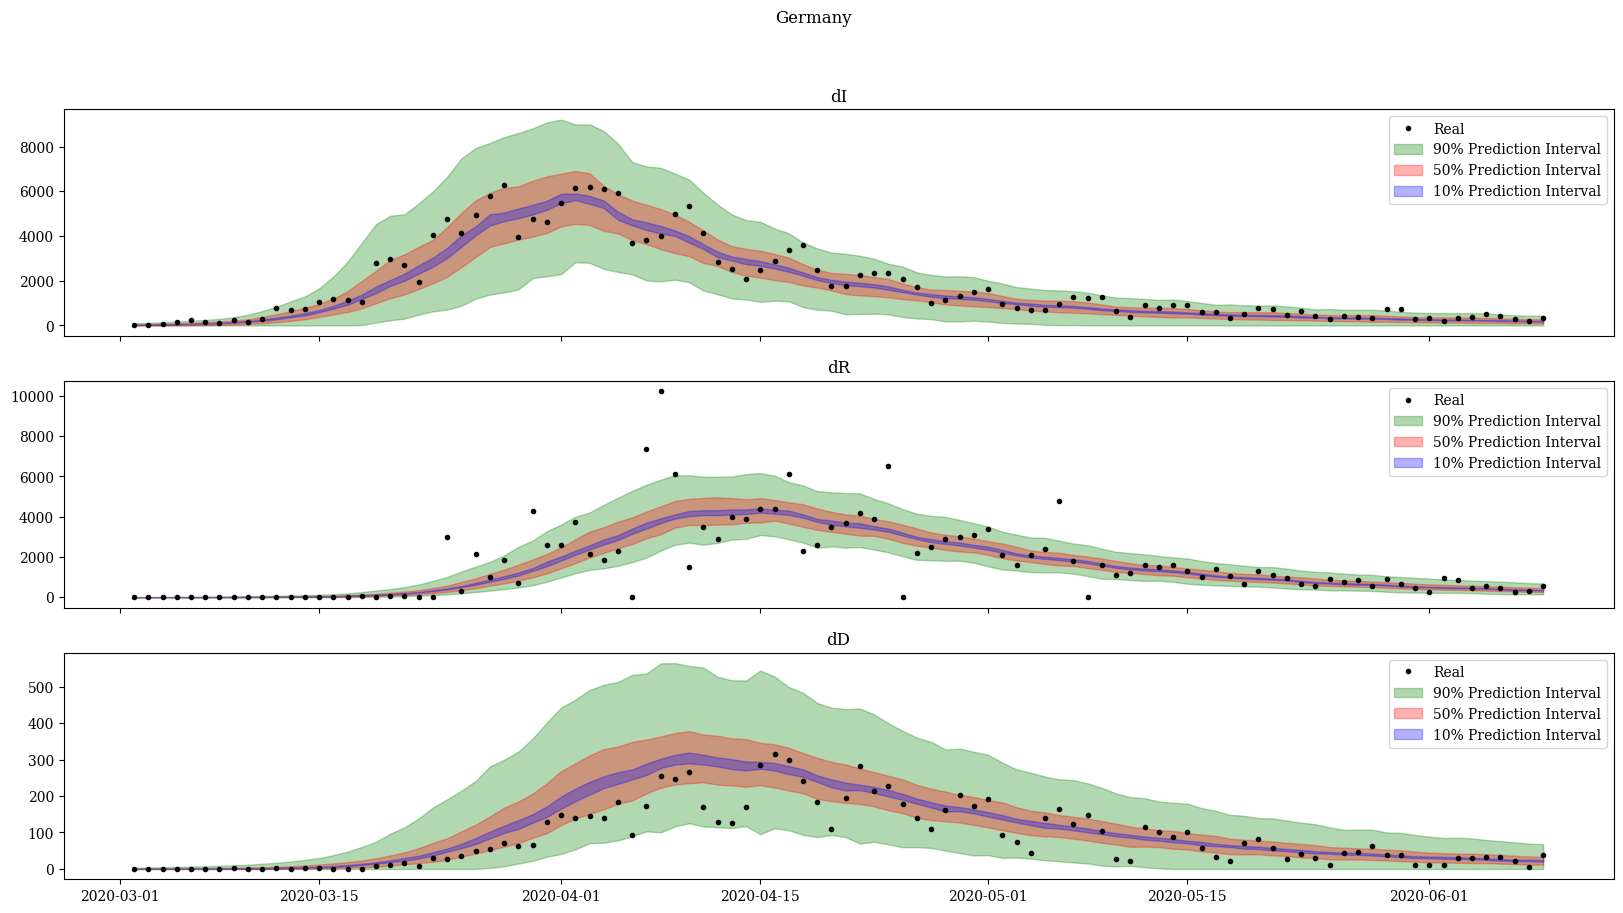

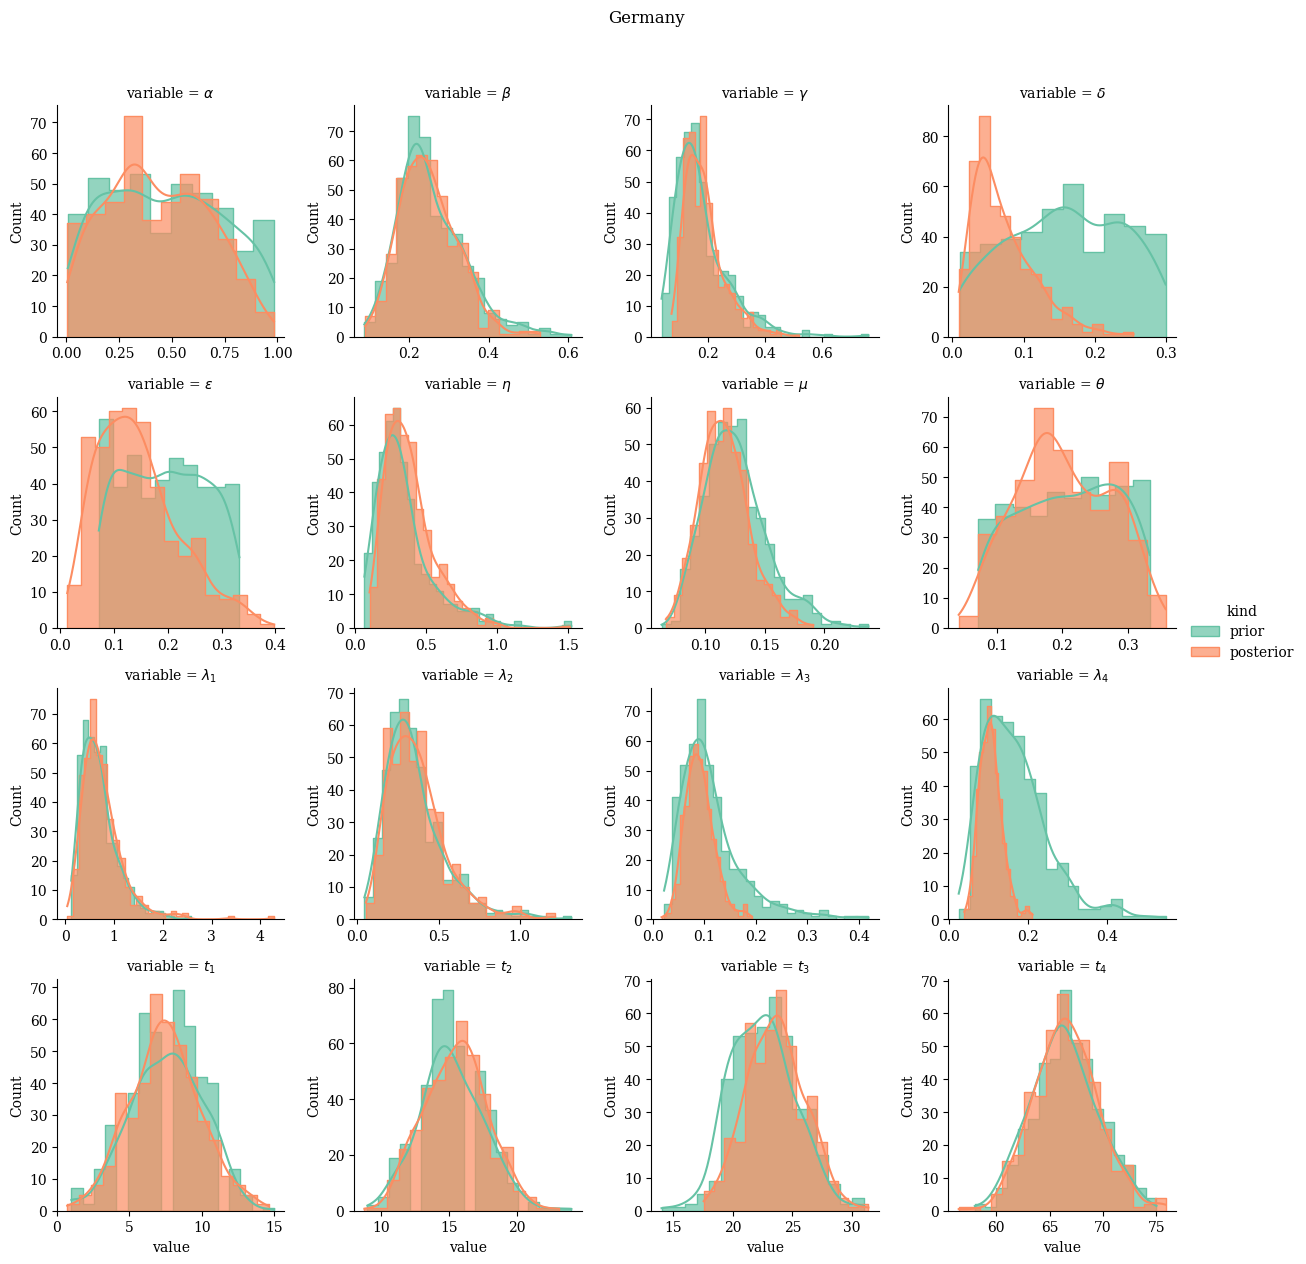

ValueError: ignored

time: 23.5 s (started: 2023-07-25 20:43:42 +00:00)


In [5]:
# predict for 1 country
cntry = 'Germany'
pred = cov.get_predictive(cntry=cntry)#, refresh=True)
# print(ps.crps_ensemble(pred['real_data'], np.median(pred['ensemble'], axis=0)).mean())

In [26]:
print(pred['real_data'])
print(pred['ensemble'])

print(pred['real_data']['dI_real'])
print(np.median(pred['ensemble']['dI_obs'], axis=0))

# print(ps.crps_ensemble(pred['ensemble']['dI_real'], np.median(pred['ensemble']['dI_obs'], axis=0)).mean())

[            dI_real  dR_real  dD_real
date                                 
2020-03-02       33        0        0
2020-03-03       38        0        0
2020-03-04       74        0        0
2020-03-05      138        0        0
2020-03-06      239        1        0
...             ...      ...      ...
2020-06-05      507      571       32
2020-06-06      407      478       33
2020-06-07      301      266       22
2020-06-08      214      332        6
2020-06-09      350      573       37

[100 rows x 3 columns]]
                                                  S             E  \
prior_idx posterior_idx t  date                                     
0         0             0  2020-03-02  4.443168e+07   6527.641865   
                        1  2020-03-03  4.442844e+07   8931.926526   
                        2  2020-03-04  4.442400e+07  12221.558108   
                        3  2020-03-05  4.441792e+07  16722.361810   
                        4  2020-03-06  4.440961e+07  22879.906602 

In [ ]:
# predict for many countries
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', sep=",")
pred = dict()
for cntry in ['Canada','US','Italy']: # Your desired list of countries
# for cntry in df['Country/Region'].sample(frac=1).unique(): # all countried in the Johns Hospkins data
    try:
        pred[cntry] = cov.get_predictive(cntry=cntry)#, refresh=True)
        print(ps.crps_ensemble(pred[cntry]['real_data'], np.median(pred[cntry]['ensemble'], axis=0)).mean())
    except Exception as e:
        print(e)